In [1]:
import pandas as pd
stock_data = pd.read_csv("/content/Stock_Data_with_vader.csv",parse_dates=["Date"],index_col="Date")

In [2]:
stock_data.head()

,Close/Last,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2015-01-02,27.3325,0.1943,0.116,0.749,0.135,27.8475,27.8600,26.8375,212575080
2015-01-05,26.5625,0.9770,0.051,0.849,0.100,27.0725,27.1625,26.3525,256843520
2015-01-06,26.5650,0.9932,0.034,0.862,0.105,26.6350,26.8575,26.1575,262729000
2015-01-07,26.9375,0.9866,0.059,0.812,0.129,26.8000,27.0500,26.6737,159933400
2015-01-08,27.9725,0.7430,0.037,0.843,0.120,27.3075,28.0375,27.1750,236675040


In [3]:
stock_data.shape

(1595, 9)

In [4]:
actual = stock_data["Close/Last"]

In [5]:
actual

Date
2015-01-02     27.3325
2015-01-05     26.5625
2015-01-06     26.5650
2015-01-07     26.9375
2015-01-08     27.9725
                ...   
2021-05-28    124.6100
2021-06-01    124.2800
2021-06-02    125.0600
2021-06-03    123.5400
2021-06-04    125.8900
Name: Close/Last, Length: 1595, dtype: float64

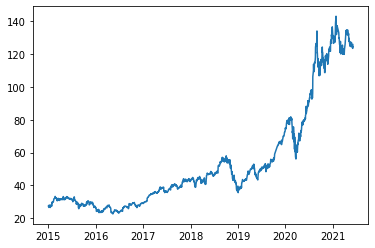

In [6]:
import matplotlib.pyplot as plt
plt.plot(actual)

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
actual = scaler.fit_transform(np.array(actual).reshape(-1,1))

In [8]:
actual

array([[0.03937383],
       [0.03298777],
       [0.0330085 ],
       ...,
       [0.84988596],
       [0.8372797 ],
       [0.85676965]])

In [9]:
training_size = int(len(actual)*0.8)
train_data = actual[0:training_size , :]
X_train = []
Y_train = []
past_days = 20
for i in range(past_days, len(train_data)):
    X_train.append(train_data[i-past_days:i, 0])
    Y_train.append(train_data[i, 0])
    if i<= past_days:
        print(X_train)
        print(Y_train)
        print()

[array([0.03937383, 0.03298777, 0.0330085 , 0.03609786, 0.04468173,
       0.04493054, 0.03920796, 0.04121916, 0.04034833, 0.0341696 ,
       0.03244868, 0.03810906, 0.03982998, 0.04573917, 0.04694174,
       0.04719055, 0.03897989, 0.05177276, 0.05921626, 0.05560854])]
[0.0586564379017209]



In [10]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1256, 20, 1)

In [12]:
print(X_train.shape)
print(Y_train.shape)

(1256, 20, 1)
(1256,)


In [13]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.LSTM(200, return_sequences=True,activation = "tanh",input_shape= (X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(80, return_sequences= False,activation = "tanh"))
model.add(keras.layers.Dense(80))
model.add(keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 200)           161600    
_________________________________________________________________
dropout (Dropout)            (None, 20, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                89920     
_________________________________________________________________
dense (Dense)                (None, 80)                6480      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 81        
Total params: 258,081
Trainable params: 258,081
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer = 'adam',loss = 'mse')

In [15]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss',mode = 'min',verbose = 1,patience = 5)

history = model.fit(X_train,Y_train, epochs = 100,batch_size = 128, validation_split = 0.4,verbose=1,callbacks = [early_stop])

Epoch 1/100
6/6 [==============================] - 5s 303ms/step - loss: 0.0025 - val_loss: 0.0115
Epoch 2/100
6/6 [==============================] - 1s 169ms/step - loss: 8.5477e-04 - val_loss: 8.8440e-04
Epoch 3/100
6/6 [==============================] - 1s 166ms/step - loss: 3.5272e-04 - val_loss: 8.7890e-04
Epoch 4/100
6/6 [==============================] - 1s 168ms/step - loss: 2.3353e-04 - val_loss: 0.0012
Epoch 5/100
6/6 [==============================] - 1s 172ms/step - loss: 1.5197e-04 - val_loss: 8.5354e-04
Epoch 6/100
6/6 [==============================] - 1s 169ms/step - loss: 9.9836e-05 - val_loss: 2.8954e-04
Epoch 7/100
6/6 [==============================] - 1s 171ms/step - loss: 8.1364e-05 - val_loss: 2.9389e-04
Epoch 8/100
6/6 [==============================] - 1s 177ms/step - loss: 7.1311e-05 - val_loss: 3.0358e-04
Epoch 9/100
6/6 [==============================] - 1s 177ms/step - loss: 7.1163e-05 - val_loss: 3.2905e-04
Epoch 10/100
6/6 [==============================]

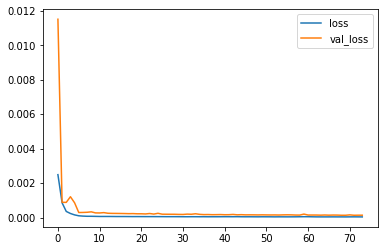

In [16]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [17]:
test_data = actual[training_size - past_days: , :]
data = stock_data["Close/Last"].values

In [18]:
X_test = []
Y_test = data[training_size:]
for i in range(past_days, len(test_data)):
    X_test.append(test_data[i-past_days:i, 0])

In [19]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test. shape[0], X_test. shape[1], 1))

In [47]:
predict = model.predict(X_test)
predict = scaler.inverse_transform(predict)

In [21]:
rmse = np.sqrt(np.mean(predict - Y_test)**2)
rmse

0.2106990343052038

In [22]:
ndata =stock_data["Close/Last"]
ndata

Date
2015-01-02     27.3325
2015-01-05     26.5625
2015-01-06     26.5650
2015-01-07     26.9375
2015-01-08     27.9725
                ...   
2021-05-28    124.6100
2021-06-01    124.2800
2021-06-02    125.0600
2021-06-03    123.5400
2021-06-04    125.8900
Name: Close/Last, Length: 1595, dtype: float64

In [23]:
training = ndata[:training_size]

In [24]:
prediction = pd.DataFrame({'Close_Price' : ndata[training_size:]})
prediction['Predictions'] = predict

In [25]:
prediction

,Close_Price,Predictions
Date,,
2020-01-29,81.0850,79.361618
2020-01-30,80.9675,79.469170
2020-01-31,77.3775,79.736000
2020-02-03,77.1650,79.631927
2020-02-04,79.7125,79.268829
...,...,...
2021-05-28,124.6100,126.484978
2021-06-01,124.2800,126.379974
2021-06-02,125.0600,126.080544


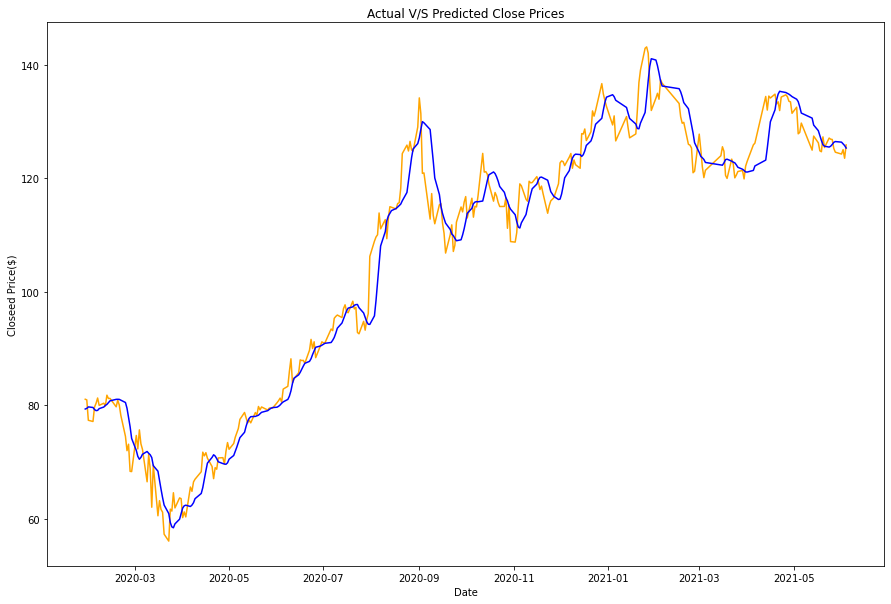

In [29]:
plt.figure(figsize=(15,10))
plt.title('Actual V/S Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel( 'Closeed Price($)')
plt.plot(prediction['Close_Price'],  color = 'orange', label = 'Actual Closed Price')
plt.plot(prediction['Predictions'],   color = 'blue' ,label = 'Predicted Closed Price')

In [30]:
import datetime

lastday =stock_data.index[-1]
nextday = lastday + datetime.timedelta(days = 1)
print(nextday)

2021-06-05 00:00:00


In [46]:
ndata = stock_data.filter(['Close/Last']).values
last20_days = ndata[-20:]
scaled_last20_days = scaler.transform(last20_days)
X_test = []
X_test.append(scaled_last20_days)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
print('Predicted Close Price for {} '.format(nextday) + ' is ', predicted_price)

Predicted Close Price for 2021-06-05 00:00:00  is  [[125.15652]]


In [45]:
previous = prediction['Predictions'].values
previous_predicted_price = previous[-1]

In [44]:
diff=(float)(predicted_price - previous_predicted_price)
if(diff < 0):
  print("percentage decrease = ",round(((- (diff)/previous_predicted_price)*100),4))
else:
  print("percentage increase = ",round((( (diff)/previous_predicted_price)*100),4))

percentage decrease =  0.1486


In [33]:
model.save("20daysPrediction.h5")